In [ ]:
!git clone https://github.com/lapudas/GreenAI.git

Cloning into 'GreenAI'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 29 (delta 8), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 44.45 KiB | 734.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
%pip install codecarbon
%pip install evaluate
%pip install rouge_score

# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3
# ollama run llama3:8b

In [ ]:
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
# Load the ROUGE metric
import evaluate
from evaluate import load
import pandas as pd

In [ ]:
!ollama list

In [ ]:
# read files(src)
# 1 document 一行，||||| 分段落
'''f = open("/content/train.src.txt","r")
train_data = f.readlines()
f.close()'''

f = open("/content/test.src.txt","r")
test_data = f.readlines()
f.close()

'''f = open("/content/val.src.txt","r")
val_data = f.readlines()
f.close()'''

print(f"test: {len(test_data)}")#(f"train: {len(train_data)}\ntest: {len(test_data)}\nval: {len(val_data)}")

In [3]:
f = open("/content/test.txt","r")
test_result = f.readlines()
f.close()

print(test_result[0])
print(len(test_result))

FileNotFoundError: [Errno 2] No such file or directory: '/content/test.txt'

In [13]:
import requests
import re

def preprocess(text):
  # Replace placeholder newline tokens
  text = text.replace("NEWLINE_CHAR", "\n")
  # Remove duplicate credits or captions
  text = re.sub(r"(jim cole\s*/\s*ap\s*)+", "", text, flags=re.IGNORECASE)
  # Normalize whitespace and lowercase
  text = re.sub(r"\s+", " ", text).strip().lower()
  return text

def chat_with_ollama(document, model="llama3:8b"):
  url = "http://localhost:11434/api/chat"
  headers = {"Content-Type": "application/json"}
  system_prompt = {
    "role": "system",
    "content": (
      "Summarize the following article into 2–3 clear and concise sentences. "
      "Output only the summary. Do not include any explanation or headings."
    )
  }

  document_parts = document.split("|||||")
  summaries = []

  for part in document_parts:
    part = preprocess(part)
    if not part.strip():
      continue
    data = {
      "model": model,
      "messages": [system_prompt, {"role": "user", "content": part}],
      "stream": False
    }
    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    summaries.append(result["message"]["content"])

  # Combine summaries
  combine_prompt = {
    "role": "system",
    "content": "Combine the following summaries into a single concise summary. Output only the summary itself."
  }
  combined_input = "\n".join(summaries)
  data = {
    "model": model,
    "messages": [combine_prompt, {"role": "user", "content": combined_input}],
    "stream": False
  }
  response = requests.post(url, headers=headers, json=data)
  result = response.json()
  return result["message"]["content"]

# print(test_data[0])
# print(chat_with_ollama(test_data[0]))

In [4]:
import os

cpu_power_path = "/usr/local/lib/python3.11/dist-packages/codecarbon/data/hardware/cpu_power.csv"
os.makedirs(os.path.dirname(cpu_power_path), exist_ok=True)

with open(cpu_power_path, "w") as f:
    f.write("Name,TDP,TDP_min,TDP_max,sockets\n")
    f.write("intel xeon 2.00ghz,85,80,95,1\n")  # placeholder values


In [ ]:
candidates = []
data_num = 1000

@track_emissions()
def summarize():
    for document in test_data[:data_num]:
        candidates.append(chat_with_ollama(document))

summarize()

串流輸出內容已截斷至最後 5000 行。
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/codecarbon/data/private_infra/global_energy_mix.json'
[codecarbon INFO @ 16:04:18] Energy consumed for RAM : 0.012789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:04:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:04:18] Energy consumed for All CPU : 0.054359 kWh
[codecarbon INFO @ 16:04:18] Energy consumed for all GPUs : 0.088726 kWh. Total GPU Power : 69.56700011074837 W
[codecarbon INFO @ 16:04:18] 0.155874 kWh of electricity used since the beginning.
[codecarbon ERROR @ 16:04:18] [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/codecarbon/data/private_infra/2016/usa_emissions.json'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
   

In [2]:
references = [i.strip("– ") for i in test_result[:data_num]]
print(references[0])

NameError: name 'test_result' is not defined

In [17]:
# rouge
rouge = evaluate.load('rouge')
results_R = rouge.compute(predictions=candidates, references=references) #結果平均

print("ROUGE:")
print(f"rouge1: {results_R['rouge1']}\nrouge2: {results_R['rouge2']}\nrougeL: {results_R['rougeL']}\nrougeLsum: {results_R['rougeLsum']}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ROUGE:
rouge1: 0.20320832948628315
rouge2: 0.058429390564267394
rougeL: 0.1312984108881206
rougeLsum: 0.1313819812545387


In [20]:
# bleu
# 不需要 brevity_prnalty，可能要考慮手動算 bleu(無BP)
bleu = evaluate.load('bleu')
results_B = bleu.compute(predictions=candidates, references=references)
print("BLEU:")
print(f"bleu: {results_B['bleu']}\nprecisions: {results_B['precisions']}\nbrevity_penalty: {results_B['brevity_penalty']}\nlength_ratio: {results_B['length_ratio']}\ntranslation_length: {results_B['translation_length']}\nreference_length: {results_B['reference_length']}")

BLEU:
bleu: 0.0023562428637233196
precisions: [0.539622641509434, 0.13846153846153847, 0.047058823529411764, 0.024]
brevity_penalty: 0.024583977303950146
length_ratio: 0.21251002405773858
translation_length: 265
reference_length: 1247


In [ ]:
'''results_R = {}
results_R['rouge1'] = 0.3042215287471872
results_R['rouge2'] = 0.08818775179799443
results_R['rougeL'] =  0.1639229255348068
results_R['rougeLsum'] = 0.16663142006267556

results_B = {}
results_B['bleu'] = 0.02515597115661552

print(results_R)'''

"results_R = {}\nresults_R['rouge1'] = 0.3042215287471872\nresults_R['rouge2'] = 0.08818775179799443\nresults_R['rougeL'] =  0.1639229255348068\nresults_R['rougeLsum'] = 0.16663142006267556\n\nresults_B = {}\nresults_B['bleu'] = 0.02515597115661552\n\nprint(results_R)"

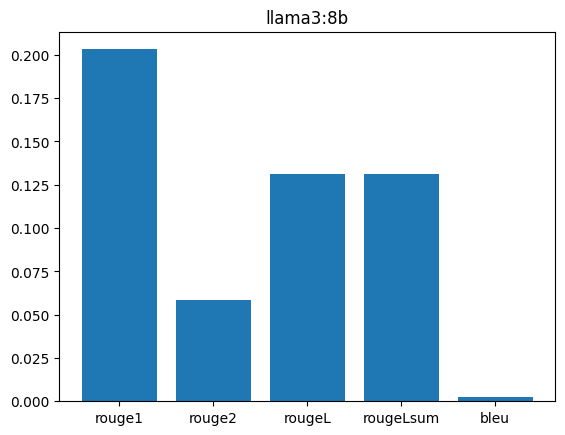

In [21]:
import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [results_R[r] for r in x[:4]] + [results_B['bleu']]
plt.bar(x,y)
plt.title("llama3:8b")
plt.show()